In [10]:
# Configure plotting in Jupyter
from matplotlib import pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore",category=mpl.cbook.mplDeprecation)
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.hot)
%matplotlib inline
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False})
# Seed random number generator
import random
from datetime import datetime
from time import time
from numpy import random as nprand
random.seed(datetime.now())
nprand.seed(int(time()))
# Import NetworkX
import networkx as nx
# Import copy
from copy import deepcopy
# Import Pandas
import pandas as pd
# Import Numpy
import numpy as np

In [11]:
class Worker:
    def __init__(self, id, initial_sentiment):
        self.id = id
        self.sentiment = initial_sentiment
        self.contacted = False
        
    def contact(self, organizer_skill=1):
        """Updates sentiment for worker based on current sentiment and organizer skill."""
        self.sentiment = min(organizer_skill + self.sentiment, 1)
        self.contacted = True

In [12]:
class Organizer:
    def __init__(self, skill):
        self.skill = skill
    
    def contact_firm(self, firm, n_contacted=1):
        """Contact random workers in the firm"""
        for i in range(n_contacted): 
            worker = random.choice(firm.workers)
            while worker.contacted:
                worker = random.choice(firm.workers)
            worker.contact(self.skill)

In [66]:
class Firm:
    def __init__(self, name, n=20, sentiment_mean=0.3, sentiment_std=0.1, m=15, p=0.7):
        self.G = nx.powerlaw_cluster_graph(n, m, p)
        self.name = name
        self.size = n
        self.sentiment_mean = sentiment_mean
        self.sentiment_std = sentiment_std
        self.workers = []
        for index, initial_sentiment in enumerate(self.init_sentiments()):
            self.workers.append(Worker(index, initial_sentiment))
        
    def init_sentiments(self):
        """Generate estimates of a true value with normally-distributed errors."""
        beliefs = [random.gauss(self.sentiment_mean, self.sentiment_std) for x in range(self.size)]
        return beliefs 
    
    def copy(self):
        return deepcopy(self)
    
    def get_neighbors(self, worker):
        return self.G.neighbors(worker.id)
    
    def learning_step(self, sentiments):
        """Update each node's beliefs based on its neighbors' beliefs"""
        new_sentiments = dict()
        for w in F.workers:
            # Include old belief in average
            total = sentiments[w.id]
            count = 1
            # Update average based on each neighbor
            for n in F.get_neighbors(w):
                total += sentiments[n]
                count += 1
            # Calculate average for node w
            new_sentiments[w.id] = total / count
        return new_sentiments
    
    def get_stats(self, display=False):
        mean_degree = np.sum([self.G.degree[node] for node in self.G.nodes()]) / float(self.size)
        adj_mat = nx.linalg.spectrum.adjacency_spectrum(self.G)
        lapl_mat = nx.linalg.spectrum.laplacian_spectrum(self.G)
        stats = {'Mean degree': [mean_degree],
                'Top adjacency matrix eigenvalues': [sorted(adj_mat, reverse=True)[:2]],
                'Top Laplacian eigenvalues': [sorted(lapl_mat, reverse=True)[:2]]}
        print(pd.DataFrame.from_dict(stats, orient='index').to_string())
        return stats
    
    def display(self):
        colors_contacted = {w.id: cmap.to_rgba(w.sentiment) for w in self.workers}
        self.get_stats(True)
        nx.draw(self.G, node_color=list(colors_contacted.values()), edgecolors=[0,0,0])
    
    def plot_sentiments(self, steps=10):
        """Plot change in plot_sentiments over time."""
        initial_sentiments = {w.id: w.sentiment for w in F.workers}
        current_sentiments = {key: value for key, value in initial_sentiments.items()}

        sentiments = [current_sentiments]
        # Create dicts of x and y values for each node
        x = dict((w.id, list()) for w in F.workers)
        y = dict((w.id, list()) for w in F.workers)
        # Repeatedly update beliefs
        for i in range(steps + 1):
            for w in F.workers:
                x[w.id].append(i)
                val = current_sentiments[w.id]
                y[w.id].append(val)
            if i < steps:
                current_sentiments = self.learning_step(current_sentiments)
                sentiments.append(current_sentiments)
        # Plot evolution of each node's beliefs
        for w in F.workers:
            plt.plot(x[w.id], y[w.id], 'b-', alpha=0.3, linewidth=2)
        # Plot mean value
        mean_value = sum(initial_sentiments.values()) / len(initial_sentiments)
        plt.plot([0, steps], [mean_value, mean_value], 'k:')
        # Add spines to plot
        ax = plt.gca()
        for spine in ax.spines.values():
            spine.set_visible(True)
        plt.xlim([0, steps])
        plt.ylim([0, 1])

### Seed 50 control firms and 50 treatment firms

In [67]:
F_control_set = [Firm('Control {}'.format(i)) for i in range(50)]
F_contacted_set = [F_control.copy() for F_control in F_control_set]
organizer = Organizer(1) 
for F_contacted in F_contacted_set:
    organizer.contact_firm(F_contacted, 5)

#### Example control firm:

                                                                                  0
Mean degree                                                                     7.5
Top adjacency matrix eigenvalues  [(9.901382038848073+0j), (1.3795045575183646+0j)]
Top Laplacian eigenvalues                  [19.999999999999996, 19.012500199469223]


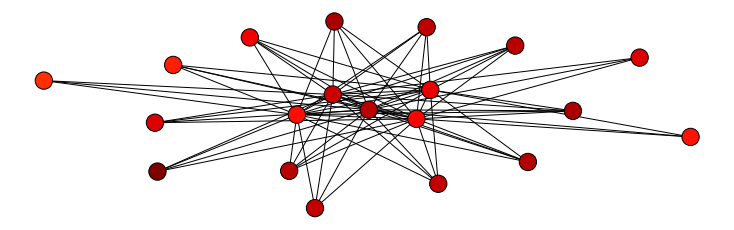

In [68]:
F_control_ex = F_control_set[0]
F_control_ex.display()

#### Example treatment firm:

                                                                                  0
Mean degree                                                                     7.5
Top adjacency matrix eigenvalues  [(9.901382038848073+0j), (1.3795045575183646+0j)]
Top Laplacian eigenvalues                  [19.999999999999996, 19.012500199469223]


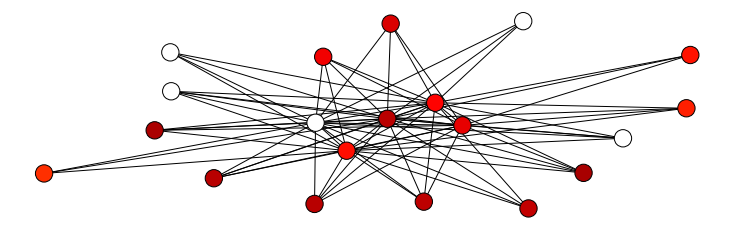

In [69]:
F_contacted_ex = F_contacted_set[0]
F_contacted_ex.display()

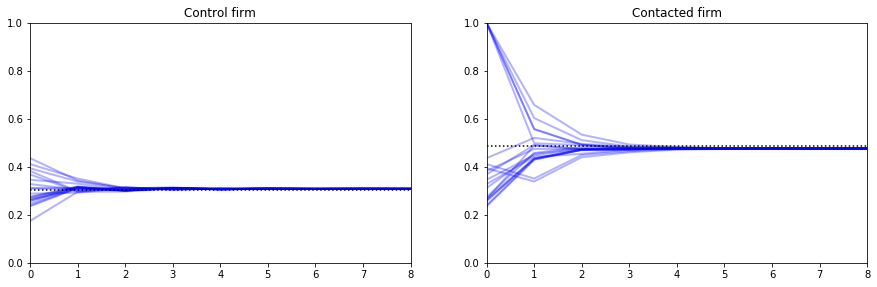

In [70]:
firms = {
    'Control firm': F_control_ex,
    'Contacted firm': F_contacted_ex }

plt.rcParams.update({'figure.figsize': (15, 15)})
for i, (title, F) in enumerate(firms.items()):
    plt.subplot(3, 2, i + 1)
    plt.title(title)
    F.plot_sentiments(8)